# Revised lec3 notebook Sept. 19

*I changed indexing below for the mean theta and wvel calculations and removed
the newaxis complication.   The dimensions of the velocity and temperature
are (time,z,y,x)  or axis=(0,1,2,3).  Hopefully the sensible heat flux profile is correct
(it's much smaller than for a dry boundary layer, because most of the energy is being
transported by vapor in the tropical marine boundary layer*

## Reading a netcdf file

1.  Fetch the netcdf file tropical.nc from my webserver (50 Mbytes)

In [78]:
import urllib.request
import numpy as np
from netCDF4 import Dataset

Only download the data once -- set this to True if you need
this file, otherwise skip

In [79]:
data_download=False  ### set this to True if running for the first time
if data_download:
    urllib.request.urlretrieve("http://clouds.eos.ubc.ca/~phil/docs/atsc500/tropical_subset.nc", 
                           "tropical_subset.nc")

2\.  Identify the file structure using ncdump

In [80]:
!ncinfo tropical_subset.nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format UNDEFINED):
    dimensions(sizes): x(100), y(110), z(112), time(1)
    variables(dimensions): float32 x(x), float32 y(y), float32 z(z), float32 time(time), float32 p(z), float32 U(time,z,y,x), float32 V(time,z,y,x), float32 W(time,z,y,x), float32 PP(time,z,y,x), float32 TABS(time,z,y,x), float32 QV(time,z,y,x), float32 QN(time,z,y,x), float32 QP(time,z,y,x)
    groups: 



3\.  Read a variable using the netCDF4 module:  http://unidata.github.io/netcdf4-python/

In [81]:
with Dataset('tropical_subset.nc','r') as nc_in:
    print(list(nc_in.variables.keys()))
    the_temp=nc_in.variables['TABS'][...]  
    #
    # remove the time dimension since we only have one timestep
    #   
    print('temp shape',the_temp.shape)
    the_height=nc_in.variables['z'][...]
    print('height shape',the_height.shape)
    the_press=nc_in.variables['p'][...]
    the_press=the_press*100.  #convert to Pa
    wvel=nc_in.variables['W'][...]

['x', 'y', 'z', 'time', 'p', 'U', 'V', 'W', 'PP', 'TABS', 'QV', 'QN', 'QP']
temp shape (1, 112, 110, 100)
height shape (112,)


# Plotting three temperature profiles

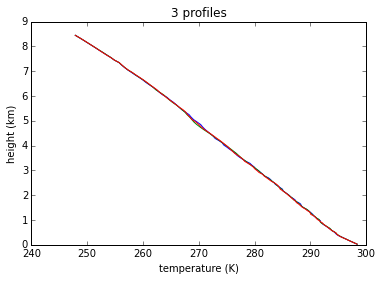

In [82]:
%matplotlib inline
#
# plot 3 arbitrary columns
#
from matplotlib import pyplot as plt
meter2km=1.e-3
random_xy=[(10,20),(80,40),(25,75)]
fig,ax=plt.subplots(1,1)
for x,y in random_xy:
    temp_profile=the_temp[0,:,x,y]
    out=ax.plot(temp_profile,the_height*meter2km)  
out=ax.set(xlabel='temperature (K)',ylabel='height (km)',title='3 profiles')

# Calculate the horizontal average temperature

In [83]:
xmean=the_temp.mean(axis=3)
print(xmean.shape)
xymean=xmean.mean(axis=2)
xymean=xymean.squeeze()
print(xymean.shape)

(1, 112, 110)
(112,)


# Calculate the temperature pertubation

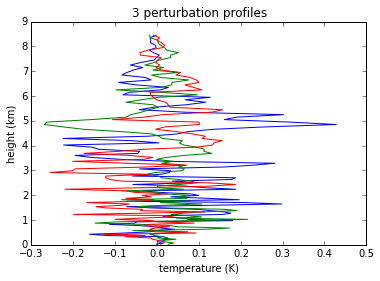

In [84]:
fig,ax=plt.subplots(1,1)
for x,y in random_xy:
    temp_profile=the_temp[0,:,x,y] - xymean
    ax.plot(temp_profile,the_height*meter2km)  
ax.set(xlabel='temperature (K)',ylabel='height (km)',title='3 perturbation profiles')

# Assignment for Wednesday, Sept. 16: 11am

1.  Write a function that takes TABS and p and returns $\theta$, the potential temperature

1.  Make a plot of the vertical profile of $\overline{w^\prime \theta^\prime}$ vs. z for
    this model timestep

1.  Upload your version of this notebook to the cloud (Dropbox, googledrive etc.) and
    email me a link

## My solution

In [85]:
def theta(p,T):
    """
      input: p (Pa), scalar pressure
             T (K),  scalar or array of temperatures
      output: thetaval (K) potential temperature
    """
    Rd=287  #dry air gas constant  J/kg/K
    cp=1004.  #dry air heat capacity at constant pressure (J/kg/K)
    p0=1.e5  #reference pressure (Pa)
    the_exp=Rd/cp
    thetaval=T*(p0/p)**the_exp
    return thetaval


### Calculate $\theta$ at every level

In [86]:
thetavals=np.empty_like(the_temp)
for lev,press_lev in enumerate(the_press):
    thetavals[0,lev,:,:]=theta(press_lev,the_temp[0,lev,:,:])   

### Plot some profiles

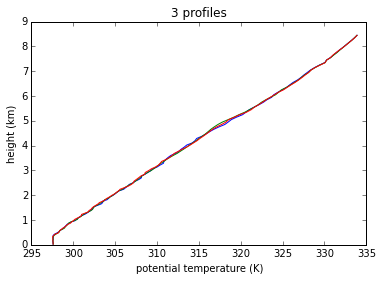

In [87]:
fig,ax=plt.subplots(1,1)
for x,y in random_xy:
    theta_profile=thetavals[0,:,x,y]
    ax.plot(theta_profile,the_height*meter2km)  
ax.set(xlabel='potential temperature (K)',ylabel='height (km)',title='3 profiles')

### Subtract average using numpy broadcasting

Find the perturbation wrt the mean theta at each height.  Because of Python's broadcasting
rules ([broadcasting](http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html)) we can't
subtract a (1,112,110,100) and a (112,) array.  Numpy will let us subtract a
(100,110,112) and a (112,) array  so we:

1) squeeze wvel to (112,110,100)

2) transpose to (100,110,112)

3) subtract the mean theta 

4) transpose back

In [88]:
w_bar=wvel[0,...].mean(axis=2).mean(axis=1)
wvel_squeeze=wvel.squeeze()
w_prime= wvel_squeeze.T - w_bar
w_prime=w_prime.T
print(w_prime.shape)

(112, 110, 100)


In [89]:
theta_bar=thetavals[0,...].mean(axis=2).mean(axis=1)
thetavals_squeeze=thetavals.squeeze()
theta_prime= thetavals_squeeze.T - theta_bar
theta_prime=theta_prime.T
print(theta_prime.shape)

(112, 110, 100)


In [90]:
flux=w_prime*theta_prime
print(flux.shape)
flux_profile=flux.mean(axis=2).mean(axis=1)
print(flux_profile.shape)

(112, 110, 100)
(112,)


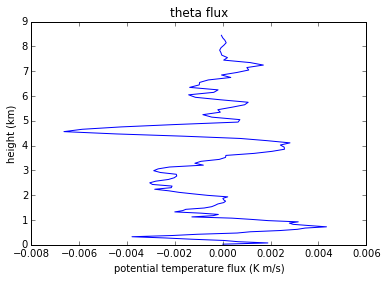

In [91]:
fig,ax=plt.subplots(1,1)
out=ax.plot(flux_profile,the_height*meter2km)
out=ax.set(xlabel='potential temperature flux (K m/s)',ylabel='height (km)',title='theta flux')

### convert kinematic flux to W/m^2

1.  Calculate the the density profile using the ideal gas law

$$p = \rho R_d T$$

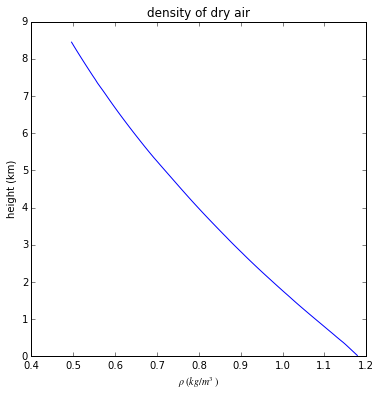

In [92]:
Rd=287 #J/kg/K
rho=the_press/(Rd*xymean)
fig,ax=plt.subplots(1,1,figsize=(6,6))
out=ax.plot(rho,the_height*meter2km)
out=ax.set(xlabel=r'$\rho\ (kg/m^3)$',ylabel='height (km)',title='density of dry air')

2\.  Calculate the enthalpy flux in $W m^{-2}$ using:

$$\rho \overline{w^\prime h^\prime} = \rho c_{pd} \left( \overline{w^\prime T^\prime} \right ) \approx \rho c_{pd} \left( \overline{w^\prime \theta^\prime} \right ) $$





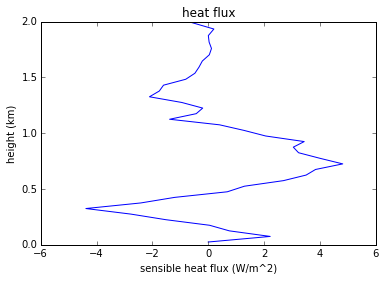

In [93]:
cpd=1004.  #J/kg/K
flux=cpd*rho*flux_profile
fig,ax=plt.subplots(1,1)
ax.plot(flux,the_height*meter2km)
ax.set(xlabel='sensible heat flux (W/m^2)',ylabel='height (km)',title='heat flux')
out=ax.set(ylim=(0,2))

# Next: Getting started with vapor

1. Install vapor per [these instructions](https://www.vapor.ucar.edu/docs/usage/getting-started-vapor)
1. Download and unzip the following file:

In [94]:
urllib.request.urlretrieve("http://clouds.eos.ubc.ca/~phil/docs/atsc500/tropical.zip", 
                           "tropical.zip")

('tropical.zip', <http.client.HTTPMessage at 0x112671d30>)

Start vapor, go to "Data -> Load dataset into current session" and see if you get a
3-d visualization of TABS

###Getting a ten member ensemble for the dry boundary layer les

# Assignment for Monday, Sept. 21

In [96]:
#get 10 files, each is the same timestep for a member of a
#10 member ensemble
if data_download:
    root='http://clouds.eos.ubc.ca/~phil/docs/atsc500/dryles'
    for i in np.arange(1,11,dtype=np.int):
        the_name='mar12014_{:d}_15600.nc'.format(i)
        print(the_name)
        url='{}/{}'.format(root,the_name)
        urllib.request.urlretrieve(url,the_name)
           

1. Hand in a notebook that

   1. plots the ensemble average theta profile for 1 column, and the ensemble averaged vertical heat flux
      in Watts/m^2 through the bottom model layer.
      
   1. histogram the normalized pressure perturbation $p^\prime/p(z)$ for 1 ensemble member
   
2. Read the rest of Stull chapter 2 and do problem 8 if you haven't already